In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from and_logic_generator import get_not_y

In [2]:
# we create 40 separable points
random_state = 2**3
x, y = make_blobs(n_samples=40, centers=2, random_state=random_state)

In [3]:
# fit the model, don't regularize for illustration purposes
model = svm.SVC(kernel='linear', C=100)
model.fit(x, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [4]:
x0_mean = x[:, 0].mean()
x0_min = x[:, 0].min() - x0_mean * 0.5
x0_max = x[:, 0].max() + x0_mean * 0.5
x1_mean = x[:, 1].mean()
x1_min = x[:, 1].min() - x1_mean * 0.5
x1_max = x[:, 1].max() + x1_mean * 0.5

In [5]:
w = model.coef_[0]
print('coef_', w)
a = -w[0] / w[1]
xx = np.linspace(x0_min, x0_max)
yy = a * xx - (model.intercept_[0]) / w[1]
print('intercept_', model.intercept_)
print(xx)
print(yy)

margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

coef_ [ 0.03245504 -0.35268672]
intercept_ [1.636684]
[ 0.54281681  0.80852577  1.07423473  1.3399437   1.60565266  1.87136162
  2.13707059  2.40277955  2.66848851  2.93419748  3.19990644  3.4656154
  3.73132437  3.99703333  4.26274229  4.52845126  4.79416022  5.05986918
  5.32557815  5.59128711  5.85699607  6.12270504  6.388414    6.65412296
  6.91983193  7.18554089  7.45124985  7.71695882  7.98266778  8.24837674
  8.51408571  8.77979467  9.04550363  9.3112126   9.57692156  9.84263052
 10.10833949 10.37404845 10.63975741 10.90546638 11.17117534 11.4368843
 11.70259326 11.96830223 12.23401119 12.49972015 12.76542912 13.03113808
 13.29684704 13.56255601]
[4.69056822 4.71501937 4.73947052 4.76392167 4.78837281 4.81282396
 4.83727511 4.86172625 4.8861774  4.91062855 4.93507969 4.95953084
 4.98398199 5.00843313 5.03288428 5.05733543 5.08178657 5.10623772
 5.13068887 5.15514001 5.17959116 5.20404231 5.22849345 5.2529446
 5.27739575 5.30184689 5.32629804 5.35074919 5.37520033 5.39965148
 5.4

In [6]:
# creating adversarial examples on SVM with linear kernal
x_test = np.array([[6.0, 1.0], [8.0, 2.0], [10.0, 10.0]], dtype=np.float32)
pred_test = model.predict(x_test)
print(pred_test)

sup_x = model.support_vectors_
dual_alpha = model.dual_coef_
beta = model.intercept_

# coef_ is only computed in linear kernel
# w = model.coef_
w = dual_alpha @ sup_x
w_l2_norm = np.sqrt(np.sum(w**2))
w_norm = w / w_l2_norm
print('w_norm:\n', w_norm)

print(x_test.shape)
print(w.shape)
Q = (x_test @ w.T + beta)
print('Q:\n', Q)

# y in set of {1, -1}. Transform label 0 to -1.
y_sign = np.array([[-1 if yy == 0 else 1 for yy in pred_test]], dtype=np.float32).T
print('y_sign:\n', y_sign)

epsilon = 1.0
delta = - w_norm * (Q + y_sign * (margin + epsilon))
adversarial = x_test + delta
print('adversarial:\n', adversarial)


[1 1 0]
w_norm:
 [[ 0.09163512 -0.99579265]]
(3, 2)
(1, 2)
Q:
 [[ 1.47872751]
 [ 1.19095087]
 [-1.56563285]]
y_sign:
 [[ 1.]
 [ 1.]
 [-1.]]
adversarial:
 [[ 5.5141345   6.27986759]
 [ 7.54050495  6.99330172]
 [10.49382908  4.63359271]]


In [7]:
def get_gradient_linear(support_x, dual_alpha):
    """
    The gradient in linear kernel does not vary based on x
    """
    return np.sum(dual_alpha.T * support_x, axis=0)

In [11]:
# Using an interative algorithm to find the minimal vector
learning_rate = 1.2
x_star = np.array(x_test)
not_y = get_not_y(pred_test)
pred_x_star = model.predict(x_star)
update_inds = np.where(pred_x_star != not_y)[0]

epoch = 0
max_epoches = 20
while len(update_inds) > 0 and epoch < max_epoches:
    update_x = x_star[update_inds] - y_sign[update_inds] * learning_rate * get_gradient_linear(sup_x, dual_alpha)    
    x_star[update_inds] = update_x

    pred_x_star = model.predict(x_star)
    update_inds = np.where(pred_x_star != not_y)[0]
    epoch = epoch + 1
        

print('before df = ', model.decision_function(x_test))
print(f'after {epoch} epochs df = ', model.decision_function(x_star))

before df =  [ 1.47872751  1.19095087 -1.56563285]
after 11 epochs df =  [-0.02656741 -0.01328493  0.09019205]


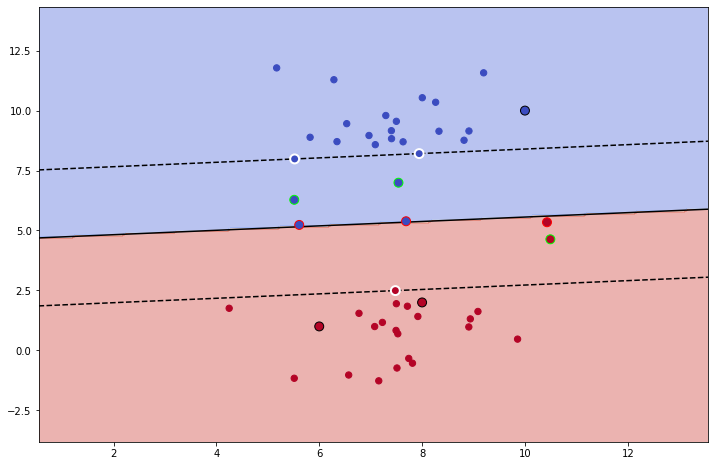

In [9]:
XX, YY = np.mgrid[x0_min:x0_max:200j, x1_min:x1_max:200j]
Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

figsize = np.array(plt.rcParams["figure.figsize"]) * 2
plt.figure(figsize=figsize.tolist())

plt.contourf(XX, YY, Z, cmap='coolwarm', alpha=0.4, zorder=1)

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', edgecolor='face', s=40, zorder=2)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], c=y[model.support_], cmap='coolwarm', edgecolors='white', linewidths=2, s=80, zorder=10)

pred_test = model.predict(x_test)
plt.scatter(x_test[:, 0], x_test[:, 1], c=pred_test, cmap='coolwarm', edgecolor='k', s=80, zorder=20)
plt.scatter(adversarial[:, 0], adversarial[:, 1], c=model.predict(adversarial), cmap='coolwarm', edgecolor='lime', s=80, zorder=20)

pred_iter_adversarials = model.predict(x_star)
plt.scatter(x_star[:, 0], x_star[:, 1], c=pred_iter_adversarials, cmap='coolwarm', edgecolor='red', s=80, zorder=20)

plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)
plt.show()

## Some links
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/svm.html

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html

https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html

https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
